## Objectives

Introduce leak at node 6, node 2. The pressure measurement of these nodes will be used as a desired output for each of the optimization. Hence, the input function will be the considered emitter coefficient value of 0.5 and optimize for 100 generations. 

## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
import shutil
warnings.filterwarnings('ignore')

In [4]:
# wipe all solutions in the directory

try:
    shutil.rmtree('../leak_size_results/no_leak/temp-new/')
    shutil.rmtree('../leak_size_results/no_leak/plots-new/')
except FileNotFoundError as e:
    print(e)

# recreate deleted folders
os.makedirs('../leak_size_results/no_leak/temp-new')
os.makedirs('../leak_size_results/no_leak/plots-new')


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

[Errno 2] No such file or directory: '../leak_size_results/no_leak/temp-new/'


## Read Inp File

In [5]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 30 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    last_fitness = 0
    mutation_percent_genes = 100
    
    
    inp_file_path = r"../data/Real_Synthetic_Net.inp" 
    function_inputs = None
    desired_output = None

In [6]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is in network 
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        
        self.node = node
        
        #Setup all neccessary folders we need to work with, i.e. create them if they don't exist
        if not os.path.exists('../leak_size_results/no_leak/temp-new/solutions_for_'+self.node):
            os.mkdir('../leak_size_results/no_leak/temp-new/solutions_for_'+self.node)
            
        if not os.path.exists('../leak_size_results/no_leak/plots-new/plots_for_'+self.node):
            os.mkdir('../leak_size_results/no_leak/plots-new/plots_for_'+self.node)
        
        if not os.path.exists('../leak_size_results/no_leak/merged_results-new/'):
            os.mkdir('../leak_size_results/no_leak/merged_results-new/')
            
        self.temp_dir = '../leak_size_results/no_leak/temp-new/solutions_for_'+self.node
        self.plots_dir = '../leak_size_results/no_leak/plots-new/plots_for_'+self.node
        self.merged_results = '../leak_size_results/no_leak/merged_results-new/results_for_'
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,self.node]
        
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        if emitter_value > 1:
            emitter_value %=1
            
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list,  name:str, path=None):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not path: path=self.merged_results
            
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
            
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=0.00015, start_time=start_time, end_time=end_time, discharge_coeff=discharge_coeff)
        results = self.simulate(wn, plot_graph=plot_graph)

        self.function_inputs = function_inputs
        self.desired_output = node.head-node.elevation
        return results


## Experiment 3 

Validating for Node without a leak

In [7]:
water_model3 = WaterLeakModel(node='N13')
wn = wntr.network.WaterNetworkModel(water_model3.inp_file_path)
pressure_at_0hr = water_model3.simulate(wn, plot_graph=False)
pressure_at_0hr.node['pressure']

,N1,N5,N10,N7,N2,N6,N3,N8,N13,N9,N14,N4,N11,N12,N15,N16,Reservior
0,9.370611,24.023646,28.970101,27.256189,24.870362,26.61794,27.085028,25.159246,30.595309,24.372273,25.061021,29.000316,27.842038,24.588272,28.966055,27.253194,0.0


In [8]:
water_model3.function_inputs = 0.5
water_model3.desired_output = 30.59

In [9]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model3.inp_file_path)
    
    results = water_model3.change_discharge_coefficient(wn, emitter_value=abs(solution[0]*water_model3.function_inputs)) #change emitter coefficient
    
    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model3.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model3.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model3.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model3.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [10]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model3.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [11]:
# Instantiate the pygad optimization class
ga_instance2 = pygad.GA(num_generations=water_model3.num_generations,
                       num_parents_mating=water_model3.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model3.sol_per_pop,
                       num_genes=water_model3.num_genes,
                       init_range_low=water_model3.init_range_low,
                       init_range_high=water_model3.init_range_high,
                       parent_selection_type=water_model3.parent_selection_type,
                       keep_parents=water_model3.keep_parents,
                       crossover_type=water_model3.crossover_type,
                       mutation_type=water_model3.mutation_type,
                       mutation_percent_genes=water_model3.mutation_percent_genes,
                       callback_generation=callback_generation)

In [12]:
ga_instance2.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 30.402 |==================| 5.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 30.476 |==================| 8.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 30.502 |==================| 11.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 30.035 |==================| 1.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 30.267 |==================| 3.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 29.979 |==================| 1.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 30.101 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 30.546 |==================| 22.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 29.856 |==================| 1.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 29.648 |==================| 1.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 30.13 |==================| 2.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 30.251 |==================| 2.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 29.572 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 30.243 |==================| 2.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 29.994 |==================| 1.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 29.515 |==================| 0.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 29.684 |==================| 1.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 29.891 |==================| 1.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 29.531 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 29.621 |==================| 1.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 29.895 |==================| 1.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 29.992 |==================| 1.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 30.141 |==================| 2.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 29.903 |==================| 1.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 30.145 |==================| 2.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 30.546 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 30.251 |==================| 2.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 29.572 |==================| 0.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 29.72 |==================| 1.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 30.514 |==================| 13.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 30.566 |==================| 42.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 30.588 |==================| 533.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 30.243 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 29.921 |==================| 1.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 29.627 |==================| 1.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 30.498 |==================| 10.918 |==========
Generation = 2
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 30.33 |==================| 3.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 29.796 |==================| 1.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 29.928 |==================| 1.51 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 30.42 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 30.154 |==================| 2.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.647 |===========| 29.884 |==================| 1.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 29.855 |==================| 1.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 29.896 |==================| 1.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 29.712 |==================| 1.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 29.484 |==================| 0.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 30.134 |==================

======| 0.541 |===========| 30.01 |==================| 1.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 30.483 |==================| 9.312 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 29.836 |==================| 1.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 29.588 |==================| 0.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 30.405 |==================| 5.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.588 |==================| 452.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 29.921 |==================| 1.494 |==========
=====|SOLUTION|===========|OUTPUT|===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 30.229 |==================| 2.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 29.76 |==================| 1.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 30.223 |==================| 2.726 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 30.009 |==================| 1.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 30.568 |==================| 44.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 30.572 |==================| 57.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 30.243 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 29.72 |==================| 1.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 29.654 |==================| 1.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 29.803 |==================| 1.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 30.253 |==================| 2.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 30.228 |==================| 2.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.813 |==================| 1.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 29.582 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 30.414 |==================| 5.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.69 |===========| 29.833 |==================| 1.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 30.588 |==================| 552.646 |==========
Change = 19.13103567502594
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.653 |==================| 1.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 30.366 |==================| 4.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.793 |===========| 29.707 |==================| 1.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 30.572 |==================| 57.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 30.243 |==================| 2.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 30.574 |==================| 64.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 30.453 |==================| 7.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 30.483 |==================| 9.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.479 |==================| 9.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 29.72 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 29.492 |==================| 0.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 29.883 |==================| 1.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 30.475 |==================| 8.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 30.094 |==================| 2.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 30.438 |==================| 6.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 29.564 |==================| 0.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 30.454 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 30.479 |==================| 9.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 29.972 |==================| 1.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 29.616 |==================| 1.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 30.045 |==================| 1.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 30.503 |==================| 11.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.642 |==================| 1.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 30.004 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 30.293 |==================| 3.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 29.955 |==================| 1.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 29.915 |==================| 1.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 30.472 |==================| 8.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.745 |===========| 29.766 |==================| 1.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 30.552 |==================| 26.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 29.492 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 29.564 |==================| 0.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 30.454 |==================| 7.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 29.625 |==================| 1.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 29.721 |==================| 1.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.62 |===========| 29.916 |==================| 1.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 29.552 |==================| 0.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 29.495 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 30.507 |==================| 12.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 29.968 |==================| 1.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 29.947 |==================| 1.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 30.208 |==================| 2.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 29.627 |==================| 1.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 29.677 |==================| 1.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 30.075 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 30.166 |==================| 2.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 29.963 |==================| 1.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.718 |===========| 29.799 |==================| 1.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 30.152 |==================| 2.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 30.203 |==================| 2.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 29.93 |==================| 1.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.642 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 29.552 |==================| 0.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 29.495 |==================| 0.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 30.591 |==================| 676.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 29.547 |==================| 0.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 29.461 |==================| 0.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 30.368 |==================| 4.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 30.507 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 29.608 |==================| 1.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 29.559 |==================| 0.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 30.212 |==================| 2.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 30.168 |==================| 2.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 29.981 |==================| 1.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.636 |==================| 1.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 29.508 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 30.291 |==================| 3.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 30.249 |==================| 2.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 29.958 |==================| 1.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 30.595 |==================| 196.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 30.417 |==================| 5.776 |==========
Fitness = 676.253667819408
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.642 |==================| 1.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.594 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 30.379 |==================| 4.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.633 |===========| 29.901 |==================| 1.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 29.53 |==================| 0.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 30.327 |==================| 3.808 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 30.282 |==================| 3.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 29.537 |==================| 0.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 29.608 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.636 |==================| 1.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 29.508 |==================| 0.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 29.666 |==================| 1.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 29.883 |==================| 1.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 30.307 |==================| 3.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 30.481 |==================| 9.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 30.291 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 29.751 |==================| 1.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 30.292 |==================| 3.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |==================| 1.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================| 1.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 30.587 |==================| 289.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 29.884 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 30.318 |==================| 3.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 30.401 |==================| 5.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 29.939 |==================| 1.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.823 |===========| 29.67 |==================| 1.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 29.992 |==================| 1.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 30.458 |==================| 7.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 30.098 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 30.178 |==================| 2.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 29.561 |==================| 0.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.62 |===========| 29.917 |==================| 1.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 30.259 |==================| 3.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 29.547 |==================| 0.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 29.658 |==================| 1.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 29.751 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.465 |==================| 8.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 29.879 |==================| 1.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 30.18 |==================| 2.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 29.828 |==================| 1.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 30.508 |==================| 12.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 29.599 |==================| 1.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 30.106 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 29.864 |==================| 1.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.871 |==================| 1.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 29.679 |==================| 1.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 29.651 |==================| 1.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 29.863 |==================| 1.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.001 |===========| 29.444 |==================| 0.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 29.543 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 30.476 |==================| 8.777 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 30.367 |==================| 4.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 29.598 |==================| 1.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 30.148 |==================| 2.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 30.588 |==================| 568.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 30.189 |==================| 2.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.465 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 29.599 |==================| 1.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 30.106 |==================| 2.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 30.139 |==================| 2.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 29.982 |==================| 1.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 30.024 |==================| 1.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |==================| 1.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 29.864 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 29.824 |==================| 1.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 30.364 |==================| 4.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 29.64 |==================| 1.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 29.507 |==================| 0.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 29.89 |==================| 1.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 30.128 |==================| 2.163 |==========
Generation = 9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 29.883 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 29.581 |==================| 0.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 29.598 |==================| 1.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 30.035 |==================| 1.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.855 |===========| 29.629 |==================| 1.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 29.516 |==================| 0.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 29.572 |==================| 0.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.587 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 29.982 |==================| 1.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 30.572 |==================| 54.724 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 30.509 |==================| 12.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 30.519 |==================| 14.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 29.573 |==================| 0.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 29.824 |==================| 1.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 30.364 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 30.394 |==================| 5.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 30.001 |==================| 1.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 30.106 |==================| 2.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 29.468 |==================| 0.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 29.628 |==================| 1.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 29.673 |==================| 1.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 29.516 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 29.624 |==================| 1.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 30.262 |==================| 3.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 30.516 |==================| 13.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 30.509 |==================| 12.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 29.851 |==================| 1.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 29.908 |==================| 1.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 30.043 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 30.165 |==================| 2.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 30.26 |==================| 3.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 29.556 |==================| 0.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 30.247 |==================| 2.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 30.022 |==================| 1.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 29.534 |==================| 0.947 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 30.394 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 29.673 |==================| 1.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 29.516 |==================| 0.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 29.671 |==================| 1.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 29.938 |==================| 1.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 29.614 |==================| 1.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 30.102 |==================| 2.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 29.624 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 29.502 |==================| 0.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 30.529 |==================| 16.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 30.442 |==================| 6.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 29.54 |==================| 0.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 30.236 |==================| 2.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 29.877 |==================| 1.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.871 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 29.89 |==================| 1.429 |==========
Fitness = 676.253667819408
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 29.9 |==================| 1.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 29.883 |==================| 1.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 30.471 |==================| 8.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 30.287 |==================| 3.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 29.694 |==================| 1.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 30.32 |==================| 3.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 30.022 |==================| 1.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 29.573 |==================| 0.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 29.746 |==================| 1.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 30.133 |==================| 2.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 29.998 |==================| 1.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 29.502 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 29.877 |==================| 1.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.871 |==================| 1.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 30.534 |==================| 17.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 30.207 |==================| 2.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 30.031 |==================| 1.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 30.15 |==================| 2.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 29.89 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 30.484 |==================| 9.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 29.687 |==================| 1.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 29.856 |==================| 1.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 30.511 |==================| 12.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 29.923 |==================| 1.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 29.752 |==================| 1.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 30.502 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 30.144 |==================| 2.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 29.704 |==================| 1.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 30.038 |==================| 1.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 29.542 |==================| 0.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 30.576 |==================| 69.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 29.863 |==================| 1.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 29.585 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 30.259 |==================| 3.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 30.374 |==================| 4.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 30.043 |==================| 1.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 30.119 |==================| 2.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 29.682 |==================| 1.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 30.38 |==================| 4.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 30.484 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 29.476 |==================| 0.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 30.318 |==================| 3.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 30.339 |==================| 3.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 30.28 |==================| 3.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 29.829 |==================| 1.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 30.317 |==================| 3.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 30.303 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================| 11.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 30.508 |==================| 12.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 29.966 |==================| 1.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 30.544 |==================| 21.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 30.172 |==================| 2.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.619 |===========| 29.918 |==================| 1.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 29.635 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 30.244 |==================| 2.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 30.058 |==================| 1.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 29.582 |==================| 0.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 30.528 |==================| 16.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 30.392 |==================| 5.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 30.392 |==================| 5.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 29.476 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 30.317 |==================| 3.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 30.303 |==================| 3.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 30.16 |==================| 2.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 30.494 |==================| 10.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 30.007 |==================| 1.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 30.582 |==================| 132.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 30.504 |==================| 11.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.198 |==================| 2.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 30.237 |==================| 2.837 |==========
Generation = 14
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 30.409 |==================| 5.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 29.558 |==================| 0.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 29.903 |==================| 1.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 29.784 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 30.359 |==================| 4.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 30.258 |==================| 3.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 30.439 |==================| 6.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 29.466 |==================| 0.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 29.65 |==================| 1.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 29.789 |==================| 1.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 29.979 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 30.416 |==================| 5.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 30.26 |==================| 3.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 30.552 |==================| 26.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 29.617 |==================| 1.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 30.229 |==================| 2.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 30.504 |==================| 11.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.198 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 30.168 |==================| 2.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 29.738 |==================| 1.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 29.893 |==================| 1.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 30.072 |==================| 1.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 30.449 |==================| 7.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 29.898 |==================| 1.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 29.89 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 30.149 |==================| 2.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.467 |==================| 0.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 29.501 |==================| 0.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 30.047 |==================| 1.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 30.453 |==================| 7.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 30.341 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 29.921 |==================| 1.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 30.439 |==================| 6.62 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 30.412 |==================| 5.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 30.07 |==================| 1.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 30.495 |==================| 10.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 30.168 |==================| 2.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 29.738 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 30.134 |==================| 2.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 29.789 |==================| 1.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 29.951 |==================| 1.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 30.498 |==================| 10.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 30.149 |==================| 2.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.467 |==================| 0.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 29.501 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 30.48 |==================| 9.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 29.936 |==================| 1.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 30.592 |==================| 657.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 29.816 |==================| 1.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 30.365 |==================| 4.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 29.881 |==================| 1.411 |==========
Generation = 16
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 30.29 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 30.325 |==================| 3.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 30.55 |==================| 24.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 29.912 |==================| 1.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.941 |===========| 29.52 |==================| 0.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 30.433 |==================| 6.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 30.177 |==================| 2.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.69 |===========| 29.833 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 30.394 |==================| 5.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 30.452 |==================| 7.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 29.568 |==================| 0.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 30.432 |==================| 6.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 30.417 |==================| 5.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 30.445 |==================| 6.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 30.48 |==================| 9

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 29.881 |==================| 1.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 30.296 |==================| 3.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 30.526 |==================| 15.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 30.227 |==================| 2.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 30.277 |==================| 3.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 29.558 |==================| 0.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.241 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 30.056 |==================| 1.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 29.756 |==================| 1.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.946 |===========| 29.515 |==================| 0.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 30.574 |==================| 61.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 29.634 |==================| 1.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 29.582 |==================| 0.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 30.234 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 30.019 |==================| 1.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 30.588 |==================| 569.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 29.456 |==================| 0.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 30.542 |==================| 20.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 30.079 |==================| 1.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.24 |==================| 2.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.802 |===========| 29.696 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 29.558 |==================| 0.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.241 |==================| 2.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 30.555 |==================| 28.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 30.397 |==================| 5.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 29.458 |==================| 0.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 29.616 |==================| 1.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 30.056 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 30.249 |==================| 2.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 29.615 |==================| 1.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 29.978 |==================| 1.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 30.023 |==================| 1.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 30.287 |==================| 3.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 30.286 |==================| 3.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 30.228 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 30.043 |==================| 1.827 |==========
Fitness = 676.253667819408
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 30.007 |==================| 1.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 29.788 |==================| 1.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 30.33 |==================| 3.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 29.647 |==================| 1.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 29.465 |==================| 0.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 30.076 |==================| 1.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 29.517 |==================| 0.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 30.046 |==================| 1.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 30.542 |==================| 20.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.812 |==================| 1.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 30.249 |==================| 2.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 29.615 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 30.228 |==================| 2.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 29.79 |==================| 1.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 29.639 |==================| 1.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 30.225 |==================| 2.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |==================| 1.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 30.334 |==================| 3.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 30.043 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.379 |==================| 4.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.634 |===========| 29.901 |==================| 1.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 29.578 |==================| 0.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 30.46 |==================| 7.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 29.788 |==================| 1.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.886 |===========| 29.59 |==================| 1.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 29.855 |==================| 1

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 29.548 |==================| 0.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 30.097 |==================| 2.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 29.501 |==================| 0.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 29.483 |==================| 0.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 29.732 |==================| 1.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 29.641 |==================| 1.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 29.823 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 29.76 |==================| 1.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 30.424 |==================| 6.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 29.657 |==================| 1.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 29.534 |==================| 0.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.379 |==================| 4.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.634 |===========| 29.901 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 29.932 |==================| 1.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 30.548 |==================| 23.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 29.679 |==================| 1.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 29.893 |==================| 1.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 29.661 |==================| 1.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 30.38 |==================| 4.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 29.498 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 29.905 |==================| 1.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 30.02 |==================| 1.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 30.198 |==================| 2.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 30.565 |==================| 39.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 29.781 |==================| 1.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 30.155 |==================| 2.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 30.087 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 30.12 |==================| 2.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 29.579 |==================| 0.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 30.417 |==================| 5.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 30.015 |==================| 1.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 30.461 |==================| 7.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 29.907 |==================| 1.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 29.932 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 30.38 |==================| 4.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 29.498 |==================| 0.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 29.738 |==================| 1.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 30.366 |==================| 4.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 30.098 |==================| 2.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 30.347 |==================| 4.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 29.905 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 30.257 |==================| 3.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 30.521 |==================| 14.481 |==========
Generation = 21
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 30.067 |==================| 1.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 29.919 |==================| 1.49 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 29.827 |==================| 1.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 30.314 |==================| 3.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 29.691 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 29.771 |==================| 1.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 29.866 |==================| 1.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 30.247 |==================| 2.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.823 |===========| 29.67 |==================| 1.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 30.372 |==================| 4.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 29.453 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 29.92 |==================| 1.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 30.361 |==================| 4.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 29.795 |==================| 1.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 29.767 |==================| 1.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 30.41 |==================| 5.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 30.257 |==================| 3.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 30.521 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 30.383 |==================| 4.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 30.592 |==================| 472.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 30.088 |==================| 1.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 30.578 |==================| 82.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 30.274 |==================| 3.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 29.682 |==================| 1.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 29.483 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 30.438 |==================| 6.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 30.167 |==================| 2.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 29.983 |==================| 1.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 30.063 |==================| 1.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 30.349 |==================| 4.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 29.542 |==================| 0.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 30.413 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 30.528 |==================| 16.24 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 30.303 |==================| 3.49 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================| 1.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 29.741 |==================| 1.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 29.755 |==================| 1.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 30.383 |==================| 4.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 30.592 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 29.483 |==================| 0.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 29.684 |==================| 1.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 30.382 |==================| 4.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 29.703 |==================| 1.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 30.574 |==================| 63.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 30.438 |==================| 6.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 30.167 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 30.237 |==================| 2.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 30.506 |==================| 11.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 30.393 |==================| 5.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 30.21 |==================| 2.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.691 |===========| 29.832 |==================| 1.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 30.464 |==================| 7.943 |==========
Generation = 23
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 30.032 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.603 |===========| 29.937 |==================| 1.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 29.87 |==================| 1.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.719 |===========| 29.798 |==================| 1.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 29.484 |==================| 0.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 29.834 |==================| 1.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 30.513 |==================| 13.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 29.877 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 29.734 |==================| 1.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 30.113 |==================| 2.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 29.772 |==================| 1.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 30.149 |==================| 2.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 30.176 |==================| 2.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 29.565 |==================| 0.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 30.237 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 30.464 |==================| 7.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.636 |==================| 1.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 30.179 |==================| 2.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 30.403 |==================| 5.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 30.426 |==================| 6.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 30.342 |==================| 4.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 29.992 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 29.685 |==================| 1.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 29.84 |==================| 1.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 29.645 |==================| 1.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 29.851 |==================| 1.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 30.226 |==================| 2.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 30.148 |==================| 2.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 29.86 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 29.475 |==================| 0.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 30.375 |==================| 4.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 30.311 |==================| 3.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 30.549 |==================| 24.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 30.108 |==================| 2.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 29.445 |==================| 0.873 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.636 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 29.992 |==================| 1.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 29.881 |==================| 1.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 29.522 |==================| 0.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 29.576 |==================| 0.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 30.574 |==================| 61.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 29.45 |==================| 0.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 29.685 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 29.511 |==================| 0.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 29.803 |==================| 1.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 30.244 |==================| 2.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 30.087 |==================| 1.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 29.585 |==================| 0.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.794 |===========| 29.705 |==================| 1.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 30.28 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 30.195 |==================| 2.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 29.509 |==================| 0.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 29.781 |==================| 1.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 29.528 |==================| 0.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 29.787 |==================| 1.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.673 |===========| 29.853 |==================| 1.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 30.538 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 29.627 |==================| 1.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 30.469 |==================| 8.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 29.55 |==================| 0.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 30.201 |==================| 2.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 29.511 |==================| 0.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 29.803 |==================| 1.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 30.244 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.24 |==================| 2.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 29.908 |==================| 1.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 29.887 |==================| 1.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 29.841 |==================| 1.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 29.842 |==================| 1.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 30.282 |==================| 3.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 29.916 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 29.461 |==================| 0.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 29.888 |==================| 1.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 30.161 |==================| 2.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 30.299 |==================| 3.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 30.543 |==================| 21.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 30.546 |==================| 22.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 29.72 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 29.755 |==================| 1.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 30.246 |==================| 2.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 29.772 |==================| 1.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 30.292 |==================| 3.356 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 30.358 |==================| 4.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 29.524 |==================| 0.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 29.817 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 30.282 |==================| 3.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 29.916 |==================| 1.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 30.096 |==================| 2.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 29.91 |==================| 1.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 30.339 |==================| 3.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 30.593 |==================| 294.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 29.461 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 29.885 |==================| 1.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.502 |===========| 30.055 |==================| 1.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.111 |==================| 2.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 30.591 |==================| 1106.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 30.532 |==================| 17.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.369 |==================| 4.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 29.723 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 30.372 |==================| 4.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 29.825 |==================| 1.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 30.503 |==================| 11.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 30.013 |==================| 1.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 30.428 |==================| 6.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.358 |===========| 30.219 |==================| 2.692 |==========
Fitness = 1106.39813676981
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 29.911 |==================| 1.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 30.463 |==================| 7.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 30.111 |==================| 2.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 29.461 |==================| 0.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 30.414 |==================| 5.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 29.927 |==================| 1.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 29.885 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.369 |==================| 4.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 29.723 |==================| 1.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 30.107 |==================| 2.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 30.367 |==================| 4.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 30.363 |==================| 4.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.036 |==================| 1.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 30.372 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 29.779 |==================| 1.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 30.016 |==================| 1.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================| 1.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 30.292 |==================| 3.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 29.804 |==================| 1.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 29.878 |==================| 1.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 30.119 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.948 |===========| 29.512 |==================| 0.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 30.122 |==================| 2.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 30.442 |==================| 6.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 29.823 |==================| 1.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 29.656 |==================| 1.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 29.758 |==================| 1.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 29.91 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 29.596 |==================| 1.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 30.531 |==================| 16.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 30.375 |==================| 4.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 30.233 |==================| 2.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 30.355 |==================| 4.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 29.779 |==================| 1.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 30.016 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.197 |==================| 2.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 30.256 |==================| 2.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 29.466 |==================| 0.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 30.272 |==================| 3.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 29.946 |==================| 1.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 30.256 |==================| 2.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 29.564 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 29.463 |==================| 0.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 30.064 |==================| 1.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 29.524 |==================| 0.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 30.053 |==================| 1.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.848 |===========| 29.638 |==================| 1.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 29.758 |==================| 1.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 29.764 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 29.567 |==================| 0.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 29.939 |==================| 1.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 30.548 |==================| 23.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 29.475 |==================| 0.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 30.266 |==================| 3.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.197 |==================| 2.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 30.256 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 29.564 |==================| 0.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 29.595 |==================| 1.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 30.473 |==================| 8.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 30.255 |==================| 2.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 30.43 |==================| 6.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 29.463 |==================| 0.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 30.064 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 29.522 |==================| 0.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 30.41 |==================| 5.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 29.877 |==================| 1.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 30.483 |==================| 9.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 29.569 |==================| 0.979 |==========
Generation = 30
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 29.572 |==================| 0.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 29.74 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 30.051 |==================| 1.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 30.084 |==================| 1.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 29.54 |==================| 0.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 30.482 |==================| 9.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 29.958 |==================| 1.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 30.232 |==================| 2.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 30.146 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 29.726 |==================| 1.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.197 |==================| 2.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 30.551 |==================| 25.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 29.789 |==================| 1.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 29.829 |==================| 1.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 30.306 |==================| 3.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 29.522 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 29.961 |==================| 1.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 30.423 |==================| 5.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 30.485 |==================| 9.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 29.941 |==================| 1.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 29.716 |==================| 1.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 29.597 |==================| 1.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 29.999 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 30.383 |==================| 4.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 29.709 |==================| 1.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 29.645 |==================| 1.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 30.165 |==================| 2.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 30.326 |==================| 3.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 29.737 |==================| 1.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 30.525 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 30.041 |==================| 1.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.509 |==================| 12.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 30.511 |==================| 12.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 29.779 |==================| 1.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 29.829 |==================| 1.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 30.47 |==================| 8.359 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 29.961 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 29.597 |==================| 1.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 29.999 |==================| 1.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 29.748 |==================| 1.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 30.067 |==================| 1.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.467 |==================| 0.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 29.821 |==================| 1.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 30.383 |==================| 4.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 30.566 |==================| 40.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 29.513 |==================| 0.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 30.019 |==================| 1.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.718 |===========| 29.8 |==================| 1.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 29.747 |==================| 1.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 29.944 |==================| 1.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 29.781 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 30.158 |==================| 2.317 |==========
Fitness = 1106.39813676981
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 29.711 |==================| 1.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 30.301 |==================| 3.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 29.94 |==================| 1.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 29.867 |==================| 1.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 30.582 |==================| 122.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 29.92 |==================| 1.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 29.535 |==================| 0.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 29.983 |==================| 1.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 29.576 |==================| 0.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 30.074 |==================| 1.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 29.93 |==================| 1.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 30.566 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 29.944 |==================| 1.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 29.781 |==================| 1.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 30.277 |==================| 3.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 29.621 |==================| 1.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 29.878 |==================| 1.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 29.618 |==================| 1.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 30.158 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 30.007 |==================| 1.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 29.822 |==================| 1.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |==================| 1.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 30.585 |==================| 211.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 29.836 |==================| 1.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 30.014 |==================| 1.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 30.552 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 30.531 |==================| 17.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 29.665 |==================| 1.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 30.124 |==================| 2.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 30.365 |==================| 4.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 29.872 |==================| 1.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 30.572 |==================| 55.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 29.823 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 29.821 |==================| 1.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 29.777 |==================| 1.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 29.807 |==================| 1.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 29.612 |==================| 1.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 30.007 |==================| 1.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 29.822 |==================| 1.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 30.395 |==================| 5.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 29.583 |==================| 0.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 29.455 |==================| 0.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 30.066 |==================| 1.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.479 |==================| 9.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 29.568 |==================| 0.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 29.754 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 30.345 |==================| 4.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 30.571 |==================| 51.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.941 |===========| 29.521 |==================| 0.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 30.134 |==================| 2.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 29.987 |==================| 1.658 |==========
Fitness = 3191.4194730624226
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 30.545 |==================| 22.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.643 |==================| 1.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 30.258 |==================| 3.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 30.152 |==================| 2.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 30.107 |==================| 2.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 30.039 |==================| 1.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 30.395 |==================| 5.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 29.583 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.68 |===========| 29.845 |==================| 1.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 30.254 |==================| 2.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 29.865 |==================| 1.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 29.863 |==================| 1.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.467 |==================| 0.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 30.345 |==================| 4.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 30.571 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 29.634 |==================| 1.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 29.774 |==================| 1.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 29.489 |==================| 0.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.673 |===========| 29.854 |==================| 1.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 29.49 |==================| 0.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 29.946 |==================| 1.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 30.549 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 30.083 |==================| 1.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 30.525 |==================| 15.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 29.734 |==================| 1.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.872 |==================| 1.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.647 |===========| 29.885 |==================| 1.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 30.563 |==================| 36.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 30.212 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 30.514 |==================| 13.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 30.109 |==================| 2.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 29.625 |==================| 1.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 30.295 |==================| 3.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 30.299 |==================| 3.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 29.49 |==================| 0.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 29.634 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 30.154 |==================| 2.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 29.599 |==================| 1.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 29.887 |==================| 1.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 29.55 |==================| 0.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 30.07 |==================| 1.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 29.732 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 30.586 |==================| 229.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 29.79 |==================| 1.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 30.04 |==================| 1.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 30.199 |==================| 2.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 29.947 |==================| 1.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 30.122 |==================| 2.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 29.767 |==================

======| 0.643 |===========| 29.889 |==================| 1.427 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 30.021 |==================| 1.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 29.769 |==================| 1.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 29.778 |==================| 1.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 29.729 |==================| 1.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 29.732 |==================| 1.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 29.554 |==================| 0.965 |==========
=====|SOLUTION|===========|OUTPUT|===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 30.07 |==================| 1.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 29.732 |==================| 1.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 30.346 |==================| 4.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 29.623 |==================| 1.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 30.542 |==================| 20.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 29.709 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.647 |===========| 29.885 |==================| 1.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 29.752 |==================| 1.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 30.593 |==================| 294.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.61 |===========| 29.928 |==================| 1.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 29.574 |==================| 0.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 29.88 |==================| 1.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 30.393 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 29.654 |==================| 1.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.17 |===========| 30.421 |==================| 5.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 30.153 |==================| 2.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 30.339 |==================| 3.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 29.944 |==================| 1.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 30.466 |==================| 8.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 30.239 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 29.572 |==================| 0.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 29.864 |==================| 1.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 30.083 |==================| 1.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 30.389 |==================| 4.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 30.43 |==================| 6.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.647 |===========| 29.885 |==================| 1.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 29.752 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 29.567 |==================| 0.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.584 |===========| 29.96 |==================| 1.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.887 |===========| 29.59 |==================| 1.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.467 |==================| 0.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |==================| 1.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 30.193 |==================| 2.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 29.454 |==================| 0.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 29.47 |==================| 0.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 30.567 |==================| 43.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 29.602 |==================| 1.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 29.501 |==================| 0.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 30.438 |==================| 6.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 30.281 |==================| 3.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 30.401 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 30.071 |==================| 1.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 29.65 |==================| 1.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 30.342 |==================| 4.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 30.049 |==================| 1.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 30.487 |==================| 9.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 29.852 |==================| 1.356 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 29.567 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 30.193 |==================| 2.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 29.454 |==================| 0.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 29.709 |==================| 1.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 29.705 |==================| 1.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 30.521 |==================| 14.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 29.522 |==================| 0.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 29.47 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 30.093 |==================| 2.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.037 |==================| 1.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 30.099 |==================| 2.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 29.875 |==================| 1.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 30.347 |==================| 4.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 30.211 |==================| 2.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 30.455 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 29.674 |==================| 1.092 |==========
Fitness = 3191.4194730624226
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 30.542 |==================| 20.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 30.042 |==================| 1.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |==================| 1.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 29.701 |==================| 1.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.653 |==================| 1.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 30.245 |==================| 2.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 30.454 |==================| 7.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.503 |===========| 30.054 |==================| 1.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 30.065 |==================| 1.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 30.394 |==================| 5.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 30.093 |==================| 2.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.037 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 29.69 |==================| 1.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 30.159 |==================| 2.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 30.357 |==================| 4.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 29.61 |==================| 1.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 29.674 |==================| 1.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.468 |==================| 0.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 30.389 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================| 11.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 29.484 |==================| 0.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 29.908 |==================| 1.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 30.362 |==================| 4.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 30.07 |==================| 1.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 29.773 |==================| 1.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 29.522 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 29.712 |==================| 1.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 30.533 |==================| 17.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 30.466 |==================| 8.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 30.02 |==================| 1.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 30.144 |==================| 2.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 29.805 |==================| 1.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 29.447 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 29.468 |==================| 0.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 30.389 |==================| 4.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 30.203 |==================| 2.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |==================| 1.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.948 |===========| 29.512 |==================| 0.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 30.483 |==================| 9.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 29.463 |==================| 0.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 30.542 |==================| 20.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 30.21 |==================| 2.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 30.472 |==================| 8.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.871 |==================| 1.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 29.787 |==================| 1.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 29.455 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 30.264 |==================| 3.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 30.365 |==================| 4.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 30.092 |==================| 2.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 29.753 |==================| 1.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 29.473 |==================| 0.896 |==========
Fitness = 3191.4194730624226
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 30.292 |==================| 3.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 29.955 |==================| 1.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 30.011 |==================| 1.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 30.284 |==================| 3.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 29.729 |==================| 1.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 30.267 |==================| 3.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 30.425 |==================| 6.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 29.463 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 29.787 |==================| 1.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 29.455 |==================| 0.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 29.61 |==================| 1.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 30.169 |==================| 2.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 30.416 |==================| 5.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 30.286 |==================| 3.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 30.264 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 29.864 |==================| 1.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 30.204 |==================| 2.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 29.504 |==================| 0.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 29.647 |==================| 1.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 29.564 |==================| 0.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 30.487 |==================| 9.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 29.863 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 30.568 |==================| 44.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 30.057 |==================| 1.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 29.585 |==================| 0.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 29.56 |==================| 0.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.37 |==================| 4.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 29.986 |==================| 1.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 30.195 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 29.892 |==================| 1.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 30.16 |==================| 2.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.636 |==================| 1.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 29.609 |==================| 1.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.479 |==================| 8.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 29.952 |==================| 1.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 29.864 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 29.836 |==================| 1.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 29.73 |==================| 1.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 29.576 |==================| 0.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 30.242 |==================| 2.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 29.518 |==================| 0.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 29.848 |==================| 1.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 30.424 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 30.072 |==================| 1.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 30.448 |==================| 7.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 30.4 |==================| 5.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 30.481 |==================| 9.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 30.027 |==================| 1.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 29.754 |==================| 1.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 30.053 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 30.235 |==================| 2.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 30.385 |==================| 4.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 29.837 |==================| 1.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 30.461 |==================| 7.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 30.401 |==================| 5.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 30.401 |==================| 5.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 29.836 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 29.848 |==================| 1.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 30.424 |==================| 6.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.878 |===========| 29.601 |==================| 1.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 30.327 |==================| 3.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 29.958 |==================| 1.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.812 |==================| 1.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 30.072 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 29.605 |==================| 1.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 30.06 |==================| 1.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 30.128 |==================| 2.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 30.553 |==================| 27.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 30.503 |==================| 11.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 30.479 |==================| 9.034 |==========
Generation = 44
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 30.278 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================| 18.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 29.57 |==================| 0.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 29.763 |==================| 1.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 30.039 |==================| 1.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 29.786 |==================| 1.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 29.93 |==================| 1.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 29.546 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 30.352 |==================| 4.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 29.81 |==================| 1.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 29.588 |==================| 0.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 30.355 |==================| 4.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 29.807 |==================| 1.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.886 |===========| 29.591 |==================| 1.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 29.605 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 30.479 |==================| 9.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 30.144 |==================| 2.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 30.039 |==================| 1.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.752 |===========| 29.758 |==================| 1.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 29.789 |==================| 1.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.511 |===========| 30.045 |==================| 1.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 30.459 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 30.539 |==================| 19.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 29.898 |==================| 1.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 29.537 |==================| 0.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 30.319 |==================| 3.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 29.609 |==================| 1.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 30.533 |==================| 17.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 30.284 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 29.773 |==================| 1.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 30.324 |==================| 3.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 29.516 |==================| 0.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 29.969 |==================| 1.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 29.874 |==================| 1.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 30.167 |==================| 2.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 30.005 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.511 |===========| 30.045 |==================| 1.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 30.459 |==================| 7.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 30.546 |==================| 22.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 30.01 |==================| 1.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 30.259 |==================| 3.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 29.576 |==================| 0.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 30.539 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 29.881 |==================| 1.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 30.582 |==================| 120.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 30.131 |==================| 2.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 30.557 |==================| 29.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 30.436 |==================| 6.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 30.549 |==================| 24.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 29.971 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 29.476 |==================| 0.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 30.089 |==================| 1.994 |==========
Fitness = 3191.4194730624226
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 30.344 |==================| 4.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 29.508 |==================| 0.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 30.27 |==================| 3.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.465 |==================| 8.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.378 |==================| 4.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 29.596 |==================| 1.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 30.42 |==================| 5.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 30.404 |==================| 5.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 29.651 |==================| 1.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 29.966 |==================| 1.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 29.881 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 29.971 |==================| 1.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 30.495 |==================| 10.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 30.281 |==================| 3.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 29.988 |==================| 1.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 29.945 |==================| 1.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 29.476 |==================| 0.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 30.089 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 29.903 |==================| 1.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 30.021 |==================| 1.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 30.424 |==================| 6.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 30.363 |==================| 4.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 29.556 |==================| 0.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 29.785 |==================| 1.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 29.524 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 29.688 |==================| 1.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 30.048 |==================| 1.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 30.013 |==================| 1.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 30.573 |==================| 58.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.51 |==================| 12.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 30.428 |==================| 6.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 29.744 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 29.552 |==================| 0.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 29.579 |==================| 0.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 30.195 |==================| 2.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 30.558 |==================| 30.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.509 |==================| 12.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 29.764 |==================| 1.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 29.903 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 30.359 |==================| 4.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 30.563 |==================| 37.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.369 |==================| 4.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 29.762 |==================| 1.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 29.654 |==================| 1.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 29.508 |==================| 0.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 29.691 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.466 |==================| 8.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 30.427 |==================| 6.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 30.229 |==================| 2.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 30.098 |==================| 2.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 30.052 |==================| 1.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 30.533 |==================| 17.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 29.876 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 29.778 |==================| 1.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 30.554 |==================| 27.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 30.264 |==================| 3.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 30.095 |==================| 2.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 29.867 |==================| 1.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 30.359 |==================| 4.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 30.563 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 29.691 |==================| 1.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 29.987 |==================| 1.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 30.513 |==================| 13.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 29.517 |==================| 0.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 30.067 |==================| 1.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.466 |==================| 8.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 30.427 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 30.278 |==================| 3.2 |==========
Generation = 49
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 30.41 |==================| 5.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 29.928 |==================| 1.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 30.049 |==================| 1.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 30.284 |==================| 3.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 29.705 |==================| 1.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.197 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 30.463 |==================| 7.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 30.569 |==================| 46.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 30.477 |==================| 8.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 30.27 |==================| 3.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.661 |===========| 29.868 |==================| 1.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 30.511 |==================| 12.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 30.371 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 30.572 |==================| 55.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 29.595 |==================| 1.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 30.091 |==================| 2.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 30.048 |==================| 1.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 30.006 |==================| 1.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 29.842 |==================| 1.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 30.278 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 30.565 |==================| 39.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 30.058 |==================| 1.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.954 |===========| 29.504 |==================| 0.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 29.967 |==================| 1.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 30.358 |==================| 4.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 30.337 |==================| 3.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 29.969 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 29.769 |==================| 1.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 29.73 |==================| 1.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 30.122 |==================| 2.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 30.125 |==================| 2.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 30.53 |==================| 16.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 30.135 |==================| 2.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 29.736 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 30.293 |==================| 3.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 29.545 |==================| 0.957 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 30.293 |==================| 3.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 29.735 |==================| 1.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 30.127 |==================| 2.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 30.466 |==================| 8.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 30.565 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 29.969 |==================| 1.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 29.948 |==================| 1.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 29.775 |==================| 1.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 30.078 |==================| 1.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 29.957 |==================| 1.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 29.769 |==================| 1.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 29.73 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.652 |==================| 1.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 30.052 |==================| 1.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 30.12 |==================| 2.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 30.415 |==================| 5.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 30.132 |==================| 2.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 30.059 |==================| 1.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.509 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 30.434 |==================| 6.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 30.346 |==================| 4.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 29.539 |==================| 0.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 30.348 |==================| 4.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.588 |==================| 456.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 29.462 |==================| 0.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 30.408 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 30.309 |==================| 3.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================| 18.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 29.973 |==================| 1.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 30.436 |==================| 6.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 29.768 |==================| 1.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 30.139 |==================| 2.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.652 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 30.059 |==================| 1.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.509 |==================| 12.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 29.611 |==================| 1.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 30.526 |==================| 15.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 30.413 |==================| 5.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 29.946 |==================| 1.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 30.238 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 30.229 |==================| 2.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 30.156 |==================| 2.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 30.275 |==================| 3.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 30.276 |==================| 3.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 29.685 |==================| 1.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 29.856 |==================| 1.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 30.486 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 30.584 |==================| 159.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 30.242 |==================| 2.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 29.65 |==================| 1.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 30.376 |==================| 4.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 30.167 |==================| 2.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 30.273 |==================| 3.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 30.016 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 29.927 |==================| 1.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 30.158 |==================| 2.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 29.971 |==================| 1.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 30.138 |==================| 2.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 30.006 |==================| 1.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 30.229 |==================| 2.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 30.156 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.719 |===========| 29.798 |==================| 1.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 30.401 |==================| 5.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 29.819 |==================| 1.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 30.169 |==================| 2.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.24 |==================| 2.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.813 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 30.448 |==================| 7.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 29.943 |==================| 1.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 30.063 |==================| 1.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 30.277 |==================| 3.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 30.138 |==================| 2.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 30.553 |==================| 26.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 29.874 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 30.58 |==================| 99.737 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 29.926 |==================| 1.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 30.264 |==================| 3.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 30.443 |==================| 6.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.719 |===========| 29.798 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.813 |==================| 1.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 30.467 |==================| 8.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.823 |===========| 29.67 |==================| 1.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 30.541 |==================| 20.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 30.053 |==================| 1.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 30.031 |==================| 1.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.592 |===========| 29.95 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 30.59 |==================| 9436.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 30.587 |==================| 287.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 30.441 |==================| 6.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 30.026 |==================| 1.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 29.896 |==================| 1.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 29.881 |==================| 1.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 29.524 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 29.715 |==================| 1.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 30.385 |==================| 4.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 29.79 |==================| 1.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 29.664 |==================| 1.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 30.578 |==================| 82.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 30.574 |==================| 63.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 29.848 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 30.236 |==================| 2.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 30.183 |==================| 2.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 30.286 |==================| 3.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 30.079 |==================| 1.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 29.519 |==================| 0.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 30.59 |==================| 9436.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 30.587 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 29.859 |==================| 1.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 30.133 |==================| 2.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 29.475 |==================| 0.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 30.046 |==================| 1.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 29.472 |==================| 0.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 30.352 |==================| 4.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 29.82 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================| 18.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 30.321 |==================| 3.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 30.294 |==================| 3.38 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 30.234 |==================| 2.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 30.102 |==================| 2.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 29.582 |==================| 0.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 30.495 |==================| 10.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 30.545 |==================| 22.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 30.595 |==================| 190.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 29.776 |==================| 1.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 30.583 |==================| 136.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 29.859 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 29.82 |==================| 1.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 30.445 |==================| 6.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 29.569 |==================| 0.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 30.082 |==================| 1.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 30.062 |==================| 1.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================| 18.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 30.321 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 29.471 |==================| 0.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 30.39 |==================| 5.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 30.171 |==================| 2.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 30.084 |==================| 1.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 30.145 |==================| 2.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 29.441 |==================| 0.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 29.587 |==================| 0.9

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 30.219 |==================| 2.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 30.277 |==================| 3.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 30.052 |==================| 1.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 30.284 |==================| 3.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 29.708 |==================| 1.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 30.573 |==================| 60.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 30.397 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 30.003 |==================| 1.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 30.485 |==================| 9.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 30.338 |==================| 3.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 30.059 |==================| 1.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 30.585 |==================| 207.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 29.653 |==================| 1.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 29.471 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 29.857 |==================| 1.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 29.68 |==================| 1.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 29.993 |==================| 1.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 29.952 |==================| 1.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 30.211 |==================| 2.635 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 29.476 |==================| 0.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 29.553 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 29.608 |==================| 1.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 29.627 |==================| 1.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 30.368 |==================| 4.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 29.543 |==================| 0.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 30.557 |==================| 29.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 30.202 |==================| 2.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 30.069 |================

======| 0.619 |===========| 29.918 |==================| 1.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 29.534 |==================| 0.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.584 |===========| 29.959 |==================| 1.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 30.488 |==================| 9.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 30.025 |==================| 1.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 29.857 |==================| 1.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 29.68 |==================| 1.099 |==========
=====|SOLUTION|===========|OUTPUT|==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 29.553 |==================| 0.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 30.532 |==================| 17.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 29.696 |==================| 1.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 30.373 |==================| 4.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 30.269 |==================| 3.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 30.247 |==================| 2.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 29.608 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 29.786 |==================| 1.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 29.844 |==================| 1.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 29.963 |==================| 1.596 |==========
Generation = 58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 30.172 |==================| 2.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 30.202 |==================| 2.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 30.426 |==================| 6.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 30.531 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.805 |===========| 29.692 |==================| 1.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 30.036 |==================| 1.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 30.569 |==================| 47.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 30.232 |==================| 2.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 30.54 |==================| 19.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 29.538 |==================| 0.951 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 29.991 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 30.01 |==================| 1.724 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 30.426 |==================| 6.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 30.557 |==================| 30.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 30.505 |==================| 11.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 30.391 |==================| 5.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 29.786 |==================| 1.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 29.844 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 29.445 |==================| 0.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 29.94 |==================| 1.539 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 30.215 |==================| 2.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 29.876 |==================| 1.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 30.344 |==================| 4.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 29.946 |==================| 1.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 29.576 |==================| 0.9

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 29.889 |==================| 1.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 29.678 |==================| 1.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 30.433 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 30.144 |==================| 2.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 29.704 |==================| 1.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 29.571 |==================| 0.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.872 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 30.183 |==================| 2.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 29.629 |==================| 1.04 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 30.127 |==================| 2.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 30.198 |==================| 2.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.036 |==================| 1.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 29.445 |==================| 0.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 29.94 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 29.576 |==================| 0.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 29.678 |==================| 1.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 30.251 |==================| 2.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 30.586 |==================| 232.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 29.795 |==================| 1.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 29.889 |==================| 1.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 29.678 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 30.247 |==================| 2.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 30.083 |==================| 1.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 30.064 |==================| 1.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 29.637 |==================| 1.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 29.468 |==================| 0.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 30.309 |==================| 3.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 30.375 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 29.726 |==================| 1.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 29.578 |==================| 0.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 29.439 |==================| 0.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.303 |===========| 30.279 |==================| 3.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 29.954 |==================| 1.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 29.675 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 30.458 |==================| 7.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 29.949 |==================| 1.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 30.439 |==================| 6.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 30.404 |==================| 5.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 29.445 |==================| 0.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 30.247 |==================| 2.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 30.083 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 30.375 |==================| 4.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 29.726 |==================| 1.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 30.024 |==================| 1.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.479 |==================| 9.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 30.014 |==================| 1.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 29.474 |==================| 0.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.802 |===========| 29.696 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 30.113 |==================| 2.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 29.825 |==================| 1.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 29.499 |==================| 0.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 30.26 |==================| 3.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 30.224 |==================| 2.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 30.546 |==================| 22.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 29.816 |==================| 1.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 29.835 |==================| 1.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 30.332 |==================| 3.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 29.765 |==================| 1.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 29.836 |==================| 1.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 30.372 |==================| 4.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 29.827 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 29.474 |==================| 0.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.802 |===========| 29.696 |==================| 1.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 30.175 |==================| 2.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 30.556 |==================| 29.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 29.867 |==================| 1.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 29.856 |==================| 1.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 30.113 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 29.984 |==================| 1.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 30.147 |==================| 2.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 30.264 |==================| 3.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 30.106 |==================| 2.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 29.742 |==================| 1.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 30.288 |==================| 3.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 29.68 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 29.477 |==================| 0.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 29.892 |==================| 1.433 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 30.384 |==================| 4.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 29.458 |==================| 0.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 29.955 |==================| 1.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 29.459 |==================| 0.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 30.446 |==================| 6.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 30.519 |==================| 14.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 30.22 |==================| 2.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 29.492 |==================| 0.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 30.299 |==================| 3.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 29.984 |==================| 1.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 30.147 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 29.68 |==================| 1.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 29.576 |==================| 0.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 29.465 |==================| 0.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 30.334 |==================| 3.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 30.426 |==================| 6.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 29.477 |==================| 0.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 29.892 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 29.788 |==================| 1.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 30.457 |==================| 7.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 29.821 |==================| 1.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 30.294 |==================| 3.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 30.105 |==================| 2.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 30.573 |==================| 59.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 30.166 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 30.333 |==================| 3.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 30.065 |==================| 1.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 30.513 |==================| 12.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 29.775 |==================| 1.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 30.295 |==================| 3.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.378 |==================| 4.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 30.45 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 30.563 |==================| 37.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 30.05 |==================| 1.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 29.716 |==================| 1.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 30.462 |==================| 7.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 29.788 |==================| 1.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 30.457 |==================| 7.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 29.821 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 30.448 |==================| 7.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 30.56 |==================| 33.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 29.711 |==================| 1.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 29.985 |==================| 1.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 30.174 |==================| 2.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 30.325 |==================| 3.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 29.746 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 30.417 |==================| 5.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 30.361 |==================| 4.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 29.503 |==================| 0.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 29.573 |==================| 0.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 30.179 |==================| 2.436 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.972 |===========| 29.481 |==================| 0.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================| 1.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 30.113 |==================| 2.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 30.26 |==================| 3.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 30.375 |==================| 4.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 30.136 |==================| 2.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 30.171 |==================| 2.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 30.448 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 30.325 |==================| 3.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 29.746 |==================| 1.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 30.271 |==================| 3.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 29.711 |==================| 1.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 29.924 |==================| 1.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 29.473 |==================| 0.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 30.417 |==================| 5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================| 11.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.478 |==================| 8.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 30.491 |==================| 10.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 29.685 |==================| 1.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 30.194 |==================| 2.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 29.988 |==================| 1.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 30.158 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 30.184 |==================| 2.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 29.889 |==================| 1.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 30.123 |==================| 2.142 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 29.939 |==================| 1.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.509 |==================| 12.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 29.567 |==================| 0.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 29.484 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 29.896 |==================| 1.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.642 |==================| 1.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 30.541 |==================| 20.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 29.62 |==================| 1.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 30.22 |==================| 2.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================| 11.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.478 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 30.34 |==================| 4.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 29.829 |==================| 1.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 30.046 |==================| 1.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 30.003 |==================| 1.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 30.445 |==================| 6.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 30.288 |==================| 3.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 29.741 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 30.224 |==================| 2.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 30.513 |==================| 12.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 29.871 |==================| 1.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 29.555 |==================| 0.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 30.25 |==================| 2.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 30.063 |==================| 1.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 29.872 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 29.888 |==================| 1.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 29.827 |==================| 1.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 30.018 |==================| 1.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 30.343 |==================| 4.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 30.551 |==================| 25.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 30.082 |==================| 1.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 30.34 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 30.288 |==================| 3.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 29.741 |==================| 1.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 30.179 |==================| 2.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 29.464 |==================| 0.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 30.236 |==================| 2.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 29.822 |==================| 1.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 30.224 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 29.897 |==================| 1.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 30.155 |==================| 2.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 30.593 |==================| 286.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 30.07 |==================| 1.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 29.877 |==================| 1.402 |==========
Generation = 67
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 29.453 |==================| 0.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 29.776 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 30.593 |==================| 359.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 30.162 |==================| 2.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 30.384 |==================| 4.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 29.485 |==================| 0.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 29.551 |==================| 0.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 29.715 |==================| 1.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 29.673 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 30.44 |==================| 6.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 29.599 |==================| 1.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 30.28 |==================| 3.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 30.273 |==================| 3.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 30.531 |==================| 16.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 30.363 |==================| 4.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 29.897 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 29.725 |==================| 1.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 30.585 |==================| 203.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 30.412 |==================| 5.618 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.686 |===========| 29.837 |==================| 1.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 30.17 |==================| 2.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 29.98 |==================| 1.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.784 |===========| 29.718 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 30.371 |==================| 4.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 29.479 |==================| 0.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 29.487 |==================| 0.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 30.384 |==================| 4.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 30.49 |==================| 10.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 30.514 |==================| 13.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 30.412 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 30.027 |==================| 1.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 30.188 |==================| 2.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 29.462 |==================| 0.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 29.796 |==================| 1.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 30.092 |==================| 2.006 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 29.725 |==================| 1.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 30.585 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.784 |===========| 29.718 |==================| 1.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 30.552 |==================| 26.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 29.755 |==================| 1.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 29.494 |==================| 0.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 30.346 |==================| 4.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 29.609 |==================| 1.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 30.371 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 30.204 |==================| 2.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 30.485 |==================| 9.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 30.333 |==================| 3.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 30.2 |==================| 2.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 30.574 |==================| 62.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.036 |==================| 1.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 30.462 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.686 |===========| 29.838 |==================| 1.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 30.202 |==================| 2.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 30.405 |==================| 5.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 30.473 |==================| 8.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 29.529 |==================| 0.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 30.5 |==================| 11.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 30.295 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 30.594 |==================| 246.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 30.227 |==================| 2.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================| 1.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 30.523 |==================| 14.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 30.525 |==================| 15.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 30.504 |==================| 11.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 30.204 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.036 |==================| 1.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 30.462 |==================| 7.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 29.801 |==================| 1.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.378 |==================| 4.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 30.473 |==================| 8.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 30.367 |==================| 4.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.936 |===========| 29.527 |==================| 0.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 30.271 |==================| 3.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 30.539 |==================| 19.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 30.57 |==================| 50.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 30.249 |==================| 2.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 30.137 |==================| 2.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 30.064 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 29.86 |==================| 1.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 29.513 |==================| 0.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 29.957 |==================| 1.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 30.083 |==================| 1.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 30.297 |==================| 3.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.823 |===========| 29.67 |==================| 1.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 29.777 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |==================| 1.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.812 |==================| 1.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 29.762 |==================| 1.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 29.784 |==================| 1.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 29.659 |==================| 1.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 30.004 |==================| 1.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.936 |===========| 29.527 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 30.584 |==================| 160.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 30.557 |==================| 30.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.152 |==================| 2.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 30.475 |==================| 8.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 30.264 |==================| 3.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 29.761 |==================| 1.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 30.274 |==================| 3.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 30.191 |==================| 2.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 29.545 |==================| 0.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 30.118 |==================| 2.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 30.548 |==================| 23.544 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.509 |==================| 12.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 30.491 |==================| 10.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 30.052 |==================| 1.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 29.566 |==================| 0.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 30.459 |==================| 7.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.303 |===========| 30.279 |==================| 3.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 30.584 |==================| 160.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 30.557 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 30.275 |==================| 3.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 30.354 |==================| 4.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 30.445 |==================| 6.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 29.772 |==================| 1.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 30.274 |==================| 3.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 30.191 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 30.033 |==================| 1.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 30.469 |==================| 8.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 30.0 |==================| 1.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 30.266 |==================| 3.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 30.1 |==================| 2.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 30.342 |==================| 4.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 29.473 |==================| 0.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 30.277 |==================| 3.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 30.022 |==================| 1.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 29.562 |==================| 0.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 29.682 |==================| 1.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 30.328 |==================| 3.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 30.221 |==================| 2.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 29.842 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 29.533 |==================| 0.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 30.201 |==================| 2.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |==================| 1.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 29.895 |==================| 1.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 30.487 |==================| 9.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 30.311 |==================| 3.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 30.033 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 30.387 |==================| 4.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 29.539 |==================| 0.951 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 30.187 |==================| 2.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 30.276 |==================| 3.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 30.056 |==================| 1.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 30.594 |==================| 279.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 30.311 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 30.373 |==================| 4.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 29.575 |==================| 0.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 30.178 |==================| 2.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 30.397 |==================| 5.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |==================| 1.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 29.473 |==================| 0.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 29.753 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 29.999 |==================| 1.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 29.975 |==================| 1.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 30.166 |==================| 2.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 30.484 |==================| 9.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 30.364 |==================| 4.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 29.563 |==================| 0.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 30.387 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 30.594 |==================| 279.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 30.311 |==================| 3.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 30.222 |==================| 2.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 30.514 |==================| 13.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 30.352 |==================| 4.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.369 |==================| 4.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 30.373 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 30.58 |==================| 101.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 29.771 |==================| 1.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 30.152 |==================| 2.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 30.554 |==================| 27.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 29.991 |==================| 1.668 |==========
Generation = 74
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 30.301 |==================| 3.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 29.779

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 29.977 |==================| 1.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 30.389 |==================| 4.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 30.134 |==================| 2.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 29.776 |==================| 1.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 29.764 |==================| 1.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 29.879 |==================| 1.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 29.882 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 29.517 |==================| 0.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 29.768 |==================| 1.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 29.987 |==================| 1.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 30.162 |==================| 2.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 29.562 |==================| 0.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 30.433 |==================| 6.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 30.58 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 30.208 |==================| 2.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 29.842 |==================| 1.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 29.556 |==================| 0.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 29.999 |==================| 1.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 30.194 |==================| 2.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 30.025 |==================| 1.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |==================| 1.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 29.483 |==================| 0.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 30.486 |==================| 9.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 29.827 |==================| 1.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 29.975 |==================| 1.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.587 |==================| 365.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 29.507 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 30.158 |==================| 2.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 30.257 |==================| 3.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 29.651 |==================| 1.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 29.783 |==================| 1.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 29.637 |==================| 1.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 29.919 |==================| 1.49 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 30.208 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 30.025 |==================| 1.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 29.839 |==================| 1.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 30.028 |==================| 1.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 29.573 |==================| 0.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 30.019 |==================| 1.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 29.916 |==================| 1.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 29.922 |==================| 1

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.633 |===========| 29.901 |==================| 1.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 30.234 |==================| 2.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 29.536 |==================| 0.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 30.501 |==================| 11.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 30.237 |==================| 2.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 29.783 |==================| 1.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 30.286 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 30.388 |==================| 4.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 29.646 |==================| 1.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 30.556 |==================| 29.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 30.0 |==================| 1.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 29.649 |==================| 1.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 29.742 |==================| 1.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 30.222 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 29.926 |==================| 1.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.855 |===========| 29.63 |==================| 1.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 29.577 |==================| 0.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 30.494 |==================| 10.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 30.35 |==================| 4.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.633 |===========| 29.901 |==================| 1.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 30.234 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 30.286 |==================| 3.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 30.433 |==================| 6.356 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 29.556 |==================| 0.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 30.501 |==================| 11.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 29.776 |==================| 1.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 29.749 |==================| 1.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 30.224 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 30.45 |==================| 7.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 30.49 |==================| 10.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.667 |===========| 29.861 |==================| 1.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 30.297 |==================| 3.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 30.067 |==================| 1.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 29.767 |==================| 1.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 30.467 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 29.755 |==================| 1.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 30.468 |==================| 8.224 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 30.34 |==================| 4.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.503 |===========| 30.054 |==================| 1.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 30.471 |==================| 8.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 30.57 |==================| 50.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 29.557 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 30.224 |==================| 2.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 30.283 |==================| 3.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 30.075 |==================| 1.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 29.869 |==================| 1.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 30.547 |==================| 23.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 30.471 |==================| 8.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 30.45 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 30.245 |==================| 2.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 29.97 |==================| 1.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 30.166 |==================| 2.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 29.874 |==================| 1.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 30.263 |==================| 3.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 29.691 |==================| 1.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 29.982 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 30.273 |==================| 3.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 30.575 |==================| 66.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 29.751 |==================| 1.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 30.365 |==================| 4.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 30.475 |==================| 8.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 30.569 |==================| 48.395 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 29.581 |==================| 0.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.762 |===========| 29.745 |==================| 1.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 30.215 |==================| 2.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.812 |==================| 1.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 30.092 |==================| 2.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 30.17 |==================| 2.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 30.245 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 29.982 |==================| 1.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 30.153 |==================| 2.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 30.359 |==================| 4.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 29.871 |==================| 1.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.635 |==================| 1.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 30.273 |==================| 3.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 30.575 |==================| 6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 29.454 |==================| 0.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 30.535 |==================| 18.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 30.556 |==================| 29.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 30.186 |==================| 2.474 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 30.354 |==================| 4.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 30.518 |==================| 13.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 29.869 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 30.016 |==================| 1.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 30.54 |==================| 20.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 30.343 |==================| 4.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.848 |===========| 29.639 |==================| 1.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 30.388 |==================| 4.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.51 |==================| 12.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 30.53 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 29.534 |==================| 0.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.706 |===========| 29.814 |==================| 1.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 30.35 |==================| 4.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 29.637 |==================| 1.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 29.454 |==================| 0.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 30.535 |==================| 1

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 29.7 |==================| 1.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 29.898 |==================| 1.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 29.967 |==================| 1.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 30.149 |==================| 2.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 30.444 |==================| 6.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 30.385 |==================| 4.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 29.815 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 30.241 |==================| 2.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 30.553 |==================| 26.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.653 |==================| 1.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 30.536 |==================| 18.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 30.567 |==================| 42.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 30.43 |==================| 6.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 30.256 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 29.952 |==================| 1.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 30.342 |==================| 4.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 30.314 |==================| 3.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 30.311 |==================| 3.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 30.461 |==================| 7.751 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 30.149 |==================| 2.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 29.7 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 29.815 |==================| 1.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 29.926 |==================| 1.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 30.441 |==================| 6.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.241 |==================| 2.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 29.703 |==================| 1.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 30.241 |==================| 2.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 30.553 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 30.395 |==================| 5.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 30.267 |==================| 3.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 30.242 |==================| 2.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 30.481 |==================| 9.196 |==========
Generation = 81
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 30.394 |==================| 5.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 30.441 |==================| 6.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 29.719 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 29.914 |==================| 1.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 29.908 |==================| 1.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 29.88 |==================| 1.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 30.569 |==================| 46.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 29.535 |==================| 0.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.825 |===========| 29.667 |==================| 1.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 30.365 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.587 |==================| 396.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================| 18.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 29.551 |==================| 0.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 29.857 |==================| 1.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.62 |===========| 29.917 |==================| 1.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 30.395 |==================| 5.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 30.267 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 29.759 |==================| 1.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 30.455 |==================| 7.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 30.464 |==================| 7.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 30.38 |==================| 4.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 30.19 |==================| 2.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.465 |==================| 8.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 29.468 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 29.595 |==================| 1.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 30.525 |==================| 15.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 29.742 |==================| 1.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 29.503 |==================| 0.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 30.565 |==================| 40.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 30.059 |==================| 1.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 29.621 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 30.321 |==================| 3.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 29.65 |==================| 1.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 29.971 |==================| 1.615 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 29.735 |==================| 1.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 29.855 |==================| 1.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 29.516 |==================| 0.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 29.759 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 30.465 |==================| 8.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 29.468 |==================| 0.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 30.558 |==================| 30.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 30.503 |==================| 11.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 29.814 |==================| 1.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 30.067 |==================| 1.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 29.595 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 30.53 |==================| 16.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 29.701 |==================| 1.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 30.047 |==================| 1.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 30.481 |==================| 9.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 29.563 |==================| 0.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 29.562 |==================| 0.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.652 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 30.032 |==================| 1.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.919 |===========| 29.549 |==================| 0.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 29.876 |==================| 1.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 30.389 |==================| 4.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 30.235 |==================| 2.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 30.318 |==================| 3.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 30.374 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 30.539 |==================| 19.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 30.407 |==================| 5.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 29.68 |==================| 1.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 30.172 |==================| 2.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 29.648 |==================| 1.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 30.507 |==================| 12.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 30.53 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 29.562 |==================| 0.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.652 |==================| 1.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 29.955 |==================| 1.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 30.274 |==================| 3.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 29.756 |==================| 1.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 29.597 |==================| 1.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.001 |===========| 29.444 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |==================| 1.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 30.49 |==================| 10.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 30.164 |==================| 2.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 30.066 |==================| 1.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 29.944 |==================| 1.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 29.81 |==================| 1.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 30.299 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 29.954 |==================| 1.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.588 |==================| 418.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 30.328 |==================| 3.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 30.295 |==================| 3.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 30.001 |==================| 1.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 30.062 |==================| 1.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 29.803 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 29.597 |==================| 1.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.001 |===========| 29.444 |==================| 0.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 29.58 |==================| 0.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 30.382 |==================| 4.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 30.415 |==================| 5.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 30.12 |==================| 2.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 29.908 |==================| 1.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 29.774 |==================| 1.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 30.487 |==================| 9.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 29.869 |==================| 1.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.853 |===========| 29.632 |==================| 1.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 29.687 |==================| 1.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 30.443 |==================| 6.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 30.556 |==================| 29.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.847 |==================| 1.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 30.476 |==================| 8.78 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 30.435 |==================| 6.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 29.906 |==================| 1.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 30.462 |==================| 7.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 29.848 |==================| 1.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 30.416 |==================| 5.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 29.926 |==================| 1.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 30.083 |==================| 1.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 30.12 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.853 |===========| 29.632 |==================| 1.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 30.537 |==================| 18.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 30.266 |==================| 3.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 30.405 |==================| 5.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 29.865 |==================| 1.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 29.672 |==================| 1.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 29.687 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.37 |==================| 4.539 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 29.479 |==================| 0.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 30.037 |==================| 1.808 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 29.507 |==================| 0.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 30.026 |==================| 1.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 30.522 |==================| 14.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 30.176 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 30.526 |==================| 15.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 29.912 |==================| 1.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 29.586 |==================| 0.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 30.588 |==================| 557.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 30.446 |==================| 6.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.844 |===========| 29.643 |==================| 1.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 29.636 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 30.311 |==================| 3.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.855 |===========| 29.63 |==================| 1.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 29.571 |==================| 0.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 30.452 |==================| 7.224 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 30.584 |==================| 154.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 30.085 |==================| 1.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 30.37 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 30.443 |==================| 6.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 29.496 |==================| 0.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 30.082 |==================| 1.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 29.558 |==================| 0.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 30.504 |==================| 11.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 30.073 |==================| 1.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 29.782 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 30.516 |==================| 13.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 29.671 |==================| 1.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 30.155 |==================| 2.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 29.53 |==================| 0.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 29.58 |==================| 0.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 30.033 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 30.41 |==================| 5.541 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 29.562 |==================| 0.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 29.56 |==================| 0.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 29.806 |==================| 1.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 29.729 |==================| 1.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 30.57 |==================| 49.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 30.443 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 30.073 |==================| 1.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 29.782 |==================| 1.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 30.474 |==================| 8.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 29.747 |==================| 1.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 30.469 |==================| 8.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 29.579 |==================| 0.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 30.545 |==================| 22.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |==================| 1.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 30.329 |==================| 3.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 30.406 |==================| 5.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 30.558 |==================| 31.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 29.503 |==================| 0.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 30.361 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 30.445 |==================| 6.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 30.224 |==================| 2.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 30.262 |==================| 3.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 29.908 |==================| 1.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 30.158 |==================| 2.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 30.384 |==================| 4.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 29.828 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 29.892 |==================| 1.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 30.362 |==================| 4.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 29.823 |==================| 1.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 29.785 |==================| 1.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 29.746 |==================| 1.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 30.545 |==================| 22.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 30.361 |==================| 4.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 29.509 |==================| 0.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 29.585 |==================| 0.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 29.753 |==================| 1.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 30.013 |==================| 1.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 29.622 |==================| 1.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 30.119 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 29.622 |==================| 1.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 30.2 |==================| 2.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 30.308 |==================| 3.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 29.713 |==================| 1.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 30.301 |==================| 3.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 30.368 |==================| 4.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 29.701 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 30.36 |==================| 4.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 29.562 |==================| 0.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 29.936 |==================| 1.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 30.24 |==================| 2.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 30.548 |==================| 23.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 30.247 |==================| 2.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 30.0 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 29.622 |==================| 1.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 30.119 |==================| 2.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 30.357 |==================| 4.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 29.826 |==================| 1.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 29.856 |==================| 1.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 30.411 |==================| 5.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 29.622 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 29.689 |==================| 1.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 30.37 |==================| 4.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.954 |===========| 29.505 |==================| 0.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 29.777 |==================| 1.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 30.382 |==================| 4.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 30.375 |==================| 4.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 29.808 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 29.844 |==================| 1.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 30.11 |==================| 2.083 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.238 |==================| 2.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 30.554 |==================| 27.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 29.865 |==================| 1.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 29.893 |==================| 1.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 30.232 |==================| 2.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 30.068 |==================| 1.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 30.158 |==================| 2.312 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 29.588 |==================| 0.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 30.399 |==================| 5.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 29.771 |==================| 1.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 29.689 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 30.375 |==================| 4.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 29.808 |==================| 1.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 30.3 |==================| 3.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.972 |===========| 29.481 |==================| 0.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 30.219 |==================| 2.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 29.902 |==================| 1.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 29.844 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 30.077 |==================| 1.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 30.183 |==================| 2.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 29.999 |==================| 1.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 30.168 |==================| 2.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 29.943 |==================| 1.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 29.803 |==================| 1.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 29.543 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 30.024 |==================| 1.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 30.519 |==================| 14.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 29.782 |==================| 1.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 29.812 |==================| 1.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.954 |===========| 29.504 |==================| 0.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 29.675 |==================| 1.093 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 29.783 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 30.486 |==================| 9.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 30.23 |==================| 2.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 29.722 |==================| 1.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 30.21 |==================| 2.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 30.539 |==================| 19.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 30.077 |==================| 1.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 30.183 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 29.542 |==================| 0.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 29.904 |==================| 1.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 30.15 |==================| 2.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 30.554 |==================| 27.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 30.43 |==================| 6.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 30.381 |==================| 4.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 30.449 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 29.463 |==================| 0.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 30.018 |==================| 1.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 29.843 |==================| 1.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 30.581 |==================| 112.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 29.607 |==================| 1.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 29.717 |==================| 1.146 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 30.394 |==================| 5.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.479 |==================| 9.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 30.312 |==================| 3.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 29.594 |==================| 1.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 29.734 |==================| 1.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 29.542 |==================| 0.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 29.904 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 29.876 |==================| 1.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 30.338 |==================| 3.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 29.621 |==================| 1.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 30.302 |==================| 3.469 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 29.463 |==================| 0.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 30.018 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.642 |==================| 1.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 29.559 |==================| 0.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 30.064 |==================| 1.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 30.51 |==================| 12.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 29.619 |==================| 1.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 29.871 |==================| 1.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 30.33 |==================| 3.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 29.996 |==================| 1.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 30.522 |==================| 14.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 29.989 |==================| 1.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 30.205 |==================| 2.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 30.272 |==================| 3.146 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 30.451 |==================| 7.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 29.577 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 29.722 |==================| 1.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 30.093 |==================| 2.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 30.214 |==================| 2.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 29.931 |==================| 1.517 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 30.239 |==================| 2.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 29.642 |==================| 1.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 29.559 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 30.264 |==================| 3.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 29.551 |==================| 0.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 29.615 |==================| 1.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 30.349 |==================| 4.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 29.662 |==================| 1.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 29.725 |==================| 1.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 29.858 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 30.5 |==================| 11.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 30.457 |==================| 7.51 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 30.086 |==================| 1.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 29.906 |==================| 1.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 29.83 |==================| 1.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 30.19 |==================| 2.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 29.451 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 29.719 |==================| 1.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 29.807 |==================| 1.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 29.452 |==================| 0.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 29.753 |==================| 1.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 30.531 |==================| 16.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 29.915 |==================| 1.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 30.264 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 29.858 |==================| 1.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 29.454 |==================| 0.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 30.049 |==================| 1.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.652 |==================| 1.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 30.309 |==================| 3.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 30.5 |==================| 11.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 30.457 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 30.207 |==================| 2.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 30.409 |==================| 5.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 30.045 |==================| 1.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 29.701 |==================| 1.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 30.57 |==================| 49.083 |==========
Generation = 95
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 30.51 |==================| 12.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 30.286 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 29.875 |==================| 1.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 29.913 |==================| 1.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 29.961 |==================| 1.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 29.677 |==================| 1.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 30.349 |==================| 4.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 29.938 |==================| 1.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 29.652 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 30.276 |==================| 3.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 30.484 |==================| 9.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 30.014 |==================| 1.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 29.775 |==================| 1.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 29.646 |==================| 1.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 30.453 |==================| 7.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 30.207 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 29.637 |==================| 1.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 30.176 |==================| 2.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 30.469 |==================| 8.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 30.395 |==================| 5.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 29.79 |==================| 1.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 30.381 |==================| 4.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.587 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 30.358 |==================| 4.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 30.003 |==================| 1.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 29.719 |==================| 1.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 30.476 |==================| 8.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 30.097 |==================| 2.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 30.53 |==================| 16.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 30.302 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 30.479 |==================| 8.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 29.455 |==================| 0.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 29.64 |==================| 1.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 30.18 |==================| 2.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 30.408 |==================| 5.502 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 29.584 |==================| 0.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 29.637 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 30.381 |==================| 4.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 30.587 |==================| 360.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 29.772 |==================| 1.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 29.608 |==================| 1.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 30.393 |==================| 5.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 30.42 |==================| 5.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 30.358 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 30.153 |==================| 2.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 30.571 |==================| 51.539 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 30.009 |==================| 1.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 29.494 |==================| 0.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 29.463 |==================| 0.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 29.754 |==================| 1.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 30.501 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 29.772 |==================| 1.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 30.392 |==================| 5.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 30.02 |==================| 1.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 29.612 |==================| 1.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 30.538 |==================| 19.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 29.899 |==================| 1.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 29.865 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 30.593 |==================| 298.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 29.958 |==================| 1.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 30.581 |==================| 108.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 30.099 |==================| 2.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.619 |===========| 29.918 |==================| 1.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 30.153 |==================| 2.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 30.571 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 30.501 |==================| 11.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 30.453 |==================| 7.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 30.386 |==================| 4.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 29.553 |==================| 0.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 29.736 |==================| 1.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 29.644 |==================| 1.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.378 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 30.295 |==================| 3.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 30.335 |==================| 3.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 29.821 |==================| 1.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 29.994 |==================| 1.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 29.941 |==================| 1.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 30.553 |==================| 26.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 30.254 |==================| 2.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 29.458 |==================| 0.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 29.874 |==================| 1.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 29.815 |==================| 1.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 30.563 |==================| 36.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 29.498 |==================| 0.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 29.877 |==================| 1.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 30.417 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 30.378 |==================| 4.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 29.865 |==================| 1.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 30.579 |==================| 93.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 29.665 |==================| 1.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 30.173 |==================| 2.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 30.295 |==================| 3.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 30.335 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 29.461 |==================| 0.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 29.714 |==================| 1.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================| 2.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 30.137 |==================| 2.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 29.65 |==================| 1.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 29.586 |==================| 0.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 29.54 |==================| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 30.02 |==================| 1.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.584 |===========| 29.96 |==================| 1.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 30.114 |==================| 2.101 |==========
Fitness = 9436.812773589429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 30.59 |==================| 2476.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 30.011 |==================| 1.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 30.161 |==================| 2.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.633 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 30.43 |==================| 6.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 30.178 |==================| 2.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 29.505 |==================| 0.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 29.573 |==================| 0.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 29.461 |==================| 0.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 29.714 |==================| 1.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 30.151 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 30.007 |==================| 1.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 29.846 |==================| 1.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 29.88 |==================| 1.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 30.581 |==================| 105.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 30.02 |==================| 1.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.584 |===========| 29.96 |==================| 1.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 30.114 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 29.756 |==================| 1.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |==================| 1.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 29.69 |==================| 1.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 30.137 |==================| 2.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 30.193 |==================| 2.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 30.018 |==================| 1.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 29.99 |==================| 1

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 30.443 |==================| 6.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 29.76 |==================| 1.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 29.625 |==================| 1.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 29.976 |==================| 1.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 30.449 |==================| 7.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 29.494 |==================| 0.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 29.912 |==================| 1.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 29.595 |==================| 1.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 29.536 |==================| 0.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 30.134 |==================| 2.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 30.372 |==================| 4.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 29.529 |==================| 0.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 29.756 |==================| 1.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |================

In [13]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance2.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 29.595 |==================| 1.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 29.536 |==================| 0.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 30.134 |==================| 2.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 30.372 |==================| 4.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 29.529 |==================| 0.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 29.756 |==================| 1.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 29.925 |================

In [14]:
# Check the model's prediction
prediction3 = numpy.sum(numpy.array(water_model3.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction3))

if ga_instance2.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance2.best_solution_generation))

Predicted output based on the best solution :0.002613770776056623
Best fitness value reached after 54 generations.


In [18]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model3.temp_dir}/GENERATION_*")
water_model3.export_results(solutions = solution_per_generation,path=None, name='optimization-result-per-generation_'+water_model3.node.lower())

result_generation = pd.read_csv(water_model3.merged_results+'/optimization-result-per-generation_'+water_model3.node.lower()+'.csv')
result_generation

File Exported Successfully to path: ../leak_size_results/no_leak/merged_results-new/results_for_/optimization-result-per-generation_n13.csv


,GENERATION,FITNESS
0,13.0,676.253668
1,12.0,676.253668
2,38.0,3191.419473
3,10.0,676.253668
4,9.0,676.253668
...,...,...
95,37.0,3191.419473
96,6.0,676.253668
97,7.0,676.253668
98,36.0,3191.419473


In [19]:
fitness_solution_per_population = glob.glob(f"{water_model3.temp_dir}/FITNESS_SOLUTION_*")

water_model3.export_results(solutions = fitness_solution_per_population, path=None, name='optimization-result-per-fitness_'+water_model3.node.lower())
fitness_solution_per_population = pd.read_csv(water_model3.merged_results+'/optimization-result-per-fitness_'+water_model3.node.lower()+'.csv')
fitness_solution_per_population

File Exported Successfully to path: ../leak_size_results/no_leak/merged_results-new/results_for_/optimization-result-per-fitness_n13.csv


,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS
0,0.020925,30.574425,1.7,64.202106
1,0.424423,30.143735,1.7,2.240817
2,0.718885,29.797933,1.7,1.262517
3,0.663413,29.864988,1.7,1.379286
4,0.112756,30.481037,1.7,9.177347
...,...,...,...,...
2825,0.741147,29.770779,1.7,1.220671
2826,0.630098,29.904842,1.7,1.459515
2827,0.994975,29.451710,1.7,0.878510
2828,0.228738,30.359121,1.7,4.331256


In [20]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='left',left_on='FITNESS',right_on='FITNESS')
final_data = final_data.sort_values(by='FITNESS',ascending=True)
final_data

,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS,GENERATION
2800,1.059228,29.368274,1.7,0.818514,NaN
824,1.004713,29.439132,1.7,0.868908,NaN
2736,1.003095,29.441224,1.7,0.870491,NaN
2027,1.002416,29.442101,1.7,0.871156,NaN
194,1.001295,29.443549,1.7,0.872257,NaN
...,...,...,...,...,...
879,0.005612,30.589722,1.7,3588.310733,50.0
878,0.005612,30.589722,1.7,3588.310733,51.0
876,0.005612,30.589722,1.7,3588.310733,49.0
881,0.005612,30.589722,1.7,3588.310733,53.0


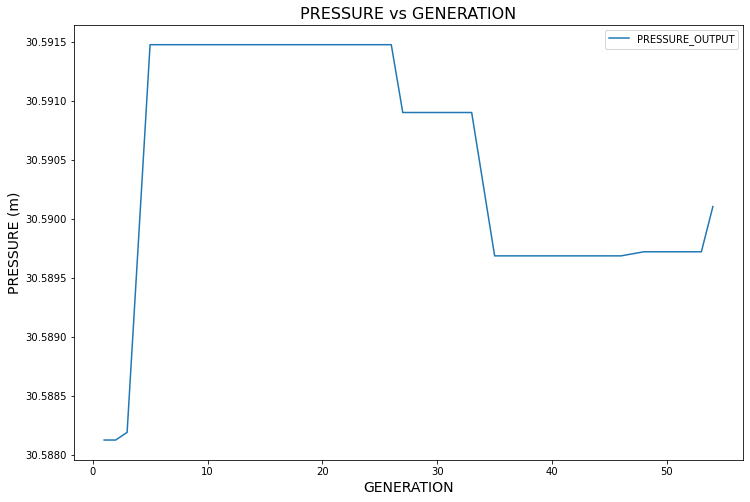

In [21]:
final_data.groupby(['GENERATION'])['PRESSURE_OUTPUT'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
plt.savefig(water_model3.plots_dir+"/PRESSURE_VS_GENERATION.png")
plt.show();
plt.close()

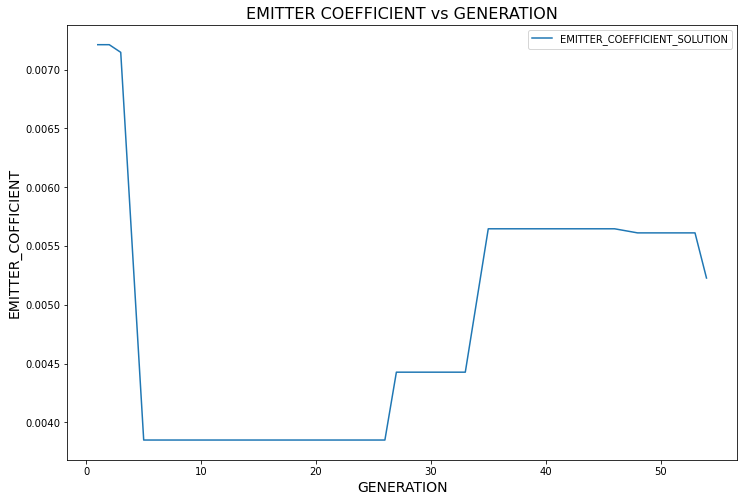

In [22]:
final_data.groupby(['GENERATION'])['EMITTER_COEFFICIENT_SOLUTION'].max().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model3.plots_dir}/EMITTER_COEFFICIENT.png");
plt.close()

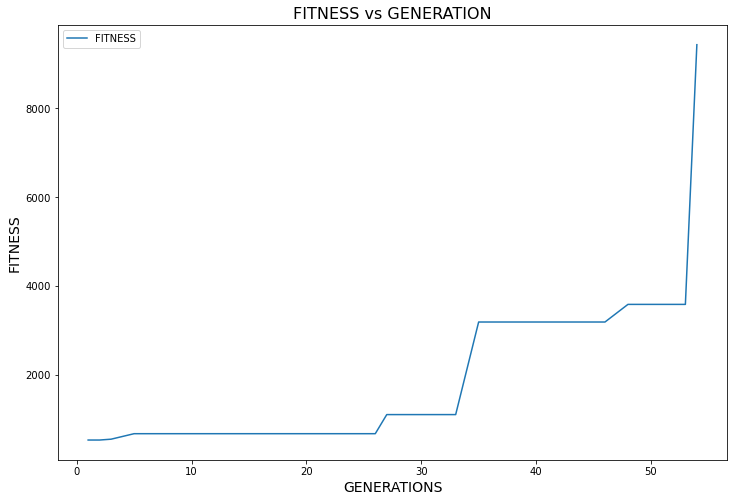

In [23]:
final_data.groupby(['GENERATION'])['FITNESS'].max().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) 
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model3.plots_dir}/FITNESS_GEN.png")
plt.close()

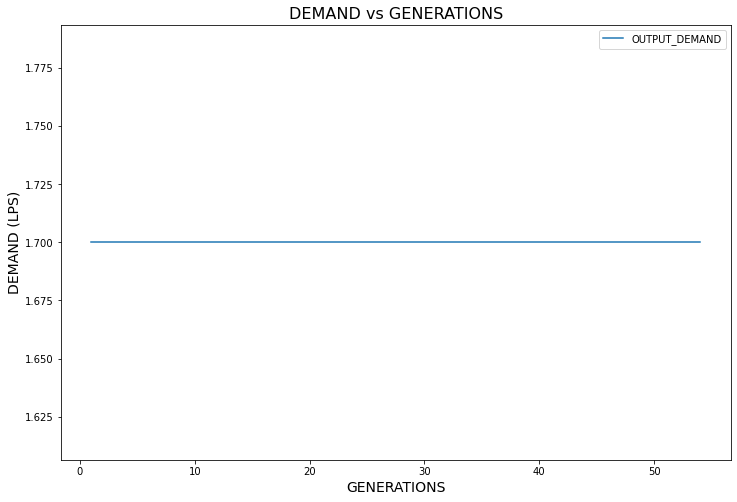

In [24]:
final_data.groupby(['GENERATION'])['OUTPUT_DEMAND'].max().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND vs GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model3.plots_dir}/DEMAND_VS_GEN.png")
plt.close()

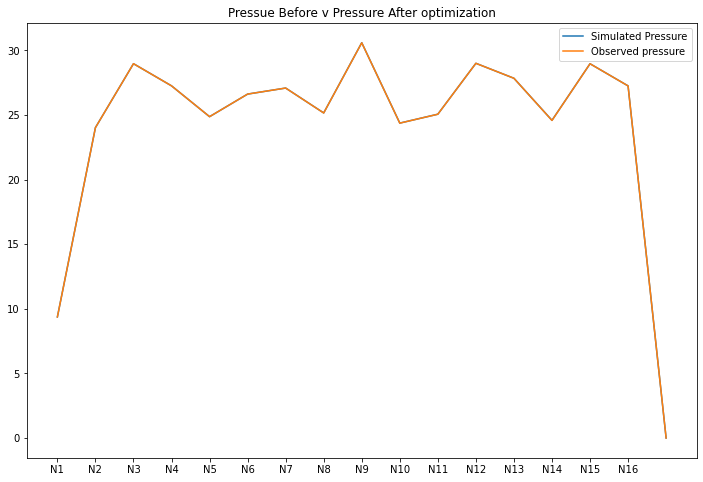

In [26]:
# Plot results on the network:
pressure_before_simulation = pressure_at_0hr.node['pressure'].iloc[:]

# Plot solution vs measurements
plt.plot(pressure_before_simulation.squeeze().values);
plt.plot(pressure.squeeze().values)
plt.legend(['Simulated Pressure','Observed pressure']);
plt.xticks(np.arange(16), ['N1','N2','N3','N4','N5','N6','N7','N8','N9','N10','N11','N12','N13','N14','N15','N16']);
plt.title('Pressue Before v Pressure After optimization');
plt.savefig(f"{water_model3.plots_dir}/pressure_before_and_after_optimization.png")